# Regression Analysis with Sampling
- Using SMOGN to sample data and make better predictions
- This is the best performing model. Modeling.ipynb doesn't use sampling so ignore, but this work is based on that nb.

In [7]:
# !pip install smogn

In [3]:
import smogn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

from xgboost import XGBRegressor


In [4]:
## read in data, drop cols, separate into X, y
df = pd.read_csv("data/dataModel.csv").dropna()
df.head()

,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Year,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,10694,0.838,0.256,1989.0,17.0,0.537,0.810,8.0,-6.213,0.0,0.1290,0.000709,0.892000,0.0579,0.667,134.096,136933.0,4.0
1,4528,0.955,0.867,0.0,1.0,0.342,0.377,11.0,-13.728,1.0,0.0401,0.943000,0.106000,0.1220,0.506,76.672,256827.0,3.0
2,3297,0.056,0.748,0.0,0.0,0.663,0.614,2.0,-7.712,1.0,0.2490,0.077100,0.006890,0.2960,0.248,82.060,87800.0,4.0
3,4435,0.740,1.000,0.0,26.0,0.163,0.262,1.0,-9.781,1.0,0.0306,0.792000,0.167000,0.1160,0.278,170.527,205347.0,4.0
4,4319,0.673,0.582,0.0,0.0,0.262,0.753,9.0,-11.859,1.0,0.0987,0.330000,0.000009,0.7180,0.087,138.553,101947.0,4.0


In [5]:
## custom train test split?
import random

def custom_split(data, test_prop=0.2):
    random.seed(699)

    train_prop = (1-test_prop)
    test_prop = test_prop

    num_train = round(len(df) * train_prop)
    num_test = round(len(df) * test_prop)

    train_idx = random.sample(range(0, len(df)-1), num_train)
    test_idx = random.sample(range(0, len(df)-1), num_test)

    _X_train = data.iloc[train_idx].drop("Popularity", axis=1).reset_index(drop=True)
    _y_train = data.iloc[train_idx]["Popularity"].reset_index(drop=True)

    _X_test = data.iloc[test_idx].drop("Popularity", axis=1).reset_index(drop=True)
    _y_test = data.iloc[test_idx]["Popularity"].reset_index(drop=True)

    print(len(df) == len(train_idx) + len(test_idx))

    return _X_train, _X_test, _y_train, _y_test

In [6]:
## make the split with the custom function
X_train, X_test, y_train, y_test = custom_split(df, test_prop=0.2)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=699)

True


In [11]:
df_train = X_train.join(y_train).sample(5000).reset_index(drop=True)

df_train.Popularity.describe()
# df_train.isnull().sum()
# y_train.isnull().sum()

count    5000.000000
mean       13.395000
std        15.505762
min         0.000000
25%         1.000000
50%         8.000000
75%        21.000000
max        83.000000
Name: Popularity, dtype: float64

In [136]:
df_smogn = smogn.smoter(
    data = df_train,
    y = "Popularity",
    k = 10,
    rel_thres=0.7,
    samp_method = "extreme"
    # rel_xtrm_type = "high"
)

# rel_thres is weird, but 0.7 best results thus far; 

r_index: 100%|##########| 264/264 [00:00<00:00, 586.19it/s]


In [137]:
df_smogn

,ArtistName,KeySignatureConfidence,TimeSignatureConfidence,Year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Popularity
0,996,0.871610,0.502857,1999.439556,0.427898,0.645294,2.719778,-7.217138,1.000000,0.034984,0.158957,0.004493,0.248581,0.107257,84.629551,252635.639968,4.0,44.715789
1,1540,0.891547,0.305054,1996.964866,0.427280,0.619139,1.350860,-7.593405,1.000000,0.036623,0.253625,0.005070,0.339194,0.145643,86.614858,254467.299483,4.0,44.715789
2,4714,0.513318,0.222835,1998.023292,0.470303,0.404438,3.023292,-8.174585,0.325569,0.046830,0.544400,0.000012,0.188671,0.254598,140.984930,254322.369017,4.0,40.390244
3,1981,0.815192,0.429976,1461.840234,0.432930,0.653932,0.732385,-7.710582,1.000000,0.038230,0.211123,0.000028,0.312491,0.210156,111.030770,254507.451216,4.0,45.278351
4,1316,0.802564,0.246663,2000.576131,0.566012,0.651998,4.660904,-8.089742,0.542387,0.038063,0.243221,0.000021,0.223343,0.427241,105.814822,255725.809572,4.0,48.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,12656,0.774000,0.000000,2007.000000,0.392000,0.876000,7.000000,-10.613000,1.000000,0.049500,0.019400,0.302000,0.103000,0.571000,152.080000,239187.000000,4.0,3.000000
4996,12872,0.205000,0.177000,0.000000,0.686000,0.048000,2.000000,-18.840000,1.000000,0.037100,0.879000,0.000000,0.075500,0.453000,130.510000,243345.000000,4.0,36.000000
4997,4584,0.000000,0.544000,0.000000,0.062800,0.895000,11.000000,-6.575000,0.000000,0.134000,0.000002,0.857000,0.823000,0.146000,68.178000,475440.000000,4.0,0.000000
4998,1682,0.520000,0.411000,1999.000000,0.291000,0.898000,7.000000,-5.247000,0.000000,0.098300,0.342000,0.101000,0.110000,0.514000,92.944000,210707.000000,4.0,13.000000


In [138]:
## split back into X_train, y_train
X_train = df_smogn.drop("Popularity", axis=1)
y_train = df_smogn.Popularity

In [139]:
## scale the data
# scaler = RobustScaler()
# X_train =  scaler.fit_transform(X_train)
# x_test = scaler.transform(X_test)

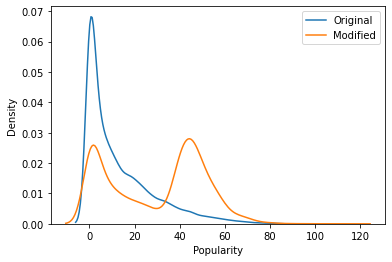

In [140]:
## distribution plot
sns.kdeplot(df['Popularity'], label = "Original")
sns.kdeplot(df_smogn['Popularity'], label = "Modified")
plt.legend();


### Dummy Regressor

In [141]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)

DummyRegressor()

In [142]:
dummy_train_r2 = dummy_reg.score(X_train, y_train)
dummy_test_r2 = dummy_reg.score(X_test, y_test)
dummy_preds = dummy_reg.predict(X_test)

dummy_RMSE = np.sqrt(mean_squared_error(y_test, dummy_preds))
dummy_MAE = mean_absolute_error(y_test, dummy_preds)

In [143]:
print(f'train r2: {dummy_train_r2}')
print(f'test r2: {dummy_test_r2}')
print(f'mae: {dummy_MAE}')
print(f'rmse: {dummy_RMSE}')
print(f'mse: {mean_squared_error(y_test, dummy_preds)}')

train r2: 0.0
test r2: -1.2465045496087823
mae: 20.356509507967562
rmse: 22.38070917538308
mse: 500.8961431930763


## Model Pipeline
After testing out many models, best performing ones are:
- Random Forest
- KNeighbors
- XGBoost
- Gradient Boosting Regressor (^^)

- GS for best parameters

In [144]:
est1 = GradientBoostingRegressor(loss="lad", max_features=None,
                                 min_samples_split=4, max_depth=7)

est2 = RandomForestRegressor(bootstrap=False, max_features="sqrt",
                             min_samples_split=3, n_estimators=100)

est3 = KNeighborsRegressor(n_neighbors=5, weights="distance")

est4 = XGBRegressor(colsample_bytree=0.9, eval_metric="mae",
                        gamma=0.3, max_depth=3, min_child_weight=2,
                        objective="reg:squarederror", subsample=1.0)

stack_reg = StackingRegressor(estimators=[('est1', est2),
                                          ('est2', est4)
                                          ],
                              final_estimator=est1)

## Let's prepare a pipeline for testing
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', stack_reg)
])

# pipe.fit(X_train, y_train)

In [145]:
# (-8.583437741074725,
#  {'reg__bootstrap': False,
#   'reg__max_features': 'sqrt',
#   'reg__min_samples_split': 3,
#   'reg__n_estimators': 100})
params_RF = {'reg__n_estimators': [100,200],
             'reg__max_features': ["log2", "sqrt", "auto"],
             'reg__min_samples_split': [2, 3, 4],
             'reg__bootstrap': [True, False]}

# (-9.79038707792391, {'reg__n_neighbors': 5, 'reg__weights': 'distance'})
params_KNN = {'reg__n_neighbors': [5, 8, 10],
              'reg__weights': ["uniform", "distance"]}

# (-9.026157811283062,
#  {'reg__colsample_bytree': 0.9,
#   'reg__eval_metric': 'mae',
#   'reg__gamma': 0.3,
#   'reg__max_depth': 3,
#   'reg__min_child_weight': 2,
#   'reg__objective': 'reg:squarederror',
#   'reg__subsample': 1.0})
params_XGB = {'reg__objective': ["reg:squarederror", "reg:linear"],
              'reg__eval_metric': ["mae", "rmse"],
              'reg__min_child_weight': [2,4,5],
              'reg__gamma':[i/10.0 for i in range(3,6)],
              'reg__subsample':[i/10.0 for i in range(6,11)],
              'reg__colsample_bytree':[i/10.0 for i in range(6,11)],
              'reg__max_depth': [2,3,4]}

# (-8.46321875834909,
#  {'reg__loss': 'lad',
#   'reg__max_depth': 7,
#   'reg__max_features': None,
#   'reg__min_samples_split': 4})
params_GBR = {'reg__loss': ["lad", "ls"],
              'reg__min_samples_split': [2, 4, 5],
              'reg__max_depth': [3, 5, 7],
              'reg__max_features': [None, 'auto', 'sqrt', 'log2']}

In [146]:
%%time
## gridsearch it with correct parameter grid

gs = GridSearchCV(pipe, param_grid={}, scoring="neg_mean_absolute_error", n_jobs=-1)
gs.fit(X_train, y_train)

gs_preds = gs.predict(X_test)

CPU times: user 41.1 s, sys: 1.01 s, total: 42.1 s
Wall time: 49.9 s


In [147]:
gs.best_score_, gs.best_params_

(-9.510220525005924, {})

In [148]:

gs_RMSE = np.sqrt(mean_squared_error(y_test, gs_preds))
gs_MAE = mean_absolute_error(y_test, gs_preds)

print(f'mae: {gs_MAE}')
print(f'rmse: {gs_RMSE}')
print(f'mse: {mean_squared_error(y_test, gs_preds)}')

mae: 9.591432259940763
rmse: 14.051906209150236
mse: 197.45606811075496


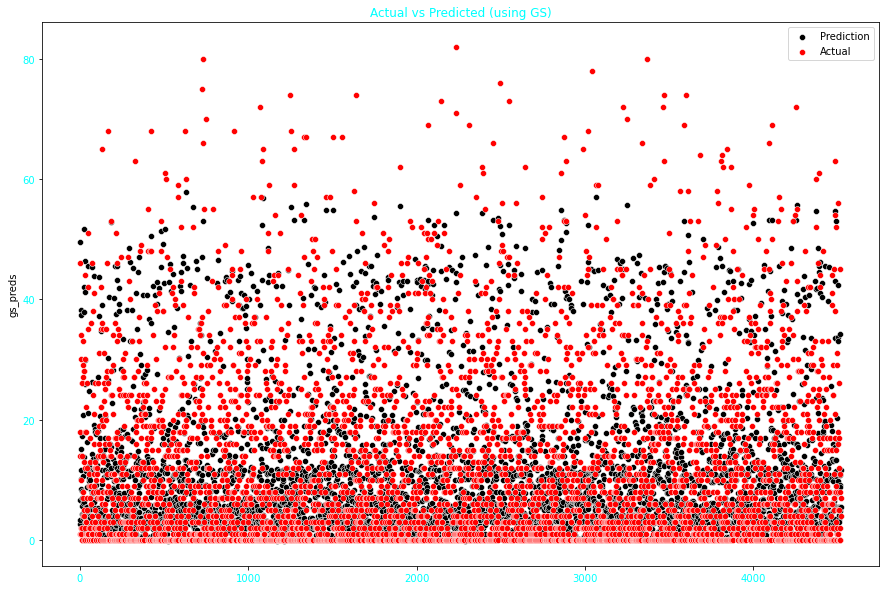

In [149]:
fig, ax = plt.subplots(figsize=(15,10))

preds_df = pd.DataFrame(list(zip(y_test, gs_preds)), columns=["y_test", "gs_preds"])
preds_df["absolute_error"] = preds_df["gs_preds"] - preds_df["y_test"]
preds_df

sns.scatterplot(x=preds_df.index, y="gs_preds", data=preds_df, ax=ax, color="black", label="Prediction")
# plt.plot(y_test - gs_preds, marker='o',linestyle='')
sns.scatterplot(x=preds_df.index, y="y_test", data=preds_df, ax=ax, color="red", label="Actual")

plt.title("Actual vs Predicted (using GS)", color="cyan");
plt.xticks(color="cyan")
plt.yticks(color="cyan");
